## Import Libraries

In [2]:
import keras.regularizers
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L2

## Definition of function to create supervised time-series data-set

In [3]:
def create_dataset(dataset, look_back=10):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Deep Regression Forest with Multi-grain scanning

In [120]:
def time_series_sliding(X, y=None, w=None):
    if w is None:
        w = 1
    stride = 1
    n_feat = X.shape[1]
    n_iter = np.floor_divide((n_feat - w), stride) + 1
    iter_array = np.arange(0, stride * n_iter, stride)
    ind_feat = np.arange(np.prod(n_feat))
    ind_to_take = [ind_feat[i:i + w] for i in iter_array]
    sliced_seq = np.take(X, ind_to_take, axis=1).reshape(-1, w)
    sliced_target = None

    if y is not None:
        sliced_target = np.repeat(y, n_iter)

    return sliced_seq, sliced_target


class Deep_Regression_Forest:

    def __init__(self, window, stride, n_tree_grain, min_samples_grain,cascade_max_depth,cascade_max_samples,
                 n_estimator_cascade, n_tree_cascade, min_samples_cascade, max_layer,verbose):
        self.cascade_test_size = 0.02
        self.n_layer = 0
        self.verbose = verbose

        self.n_estimator_cascade = n_estimator_cascade
        self.n_tree_cascade = n_tree_cascade
        self.min_samples_cascade = min_samples_cascade
        self.cascade_max_depth = cascade_max_depth
        self.cascade_max_samples = cascade_max_samples
        self.max_layer = max_layer

        self.n_tree_grain = n_tree_grain
        self.min_samples_grain = min_samples_grain
        self.window = window
        self.stride = stride

    def fit(self, X, y):
        X_grain = self.sliding_prediction(X, y)
        X_new = self.first_layer_cascade(X_grain, X, y)
        _ = self.cascade_forest(X_new, X, y)

    def predict(self,X):
        X_grain = self.sliding_prediction(X)
        X_new = self.first_layer_cascade(X_grain, X)
        pred = self.cascade_forest(X_new, X)
        return np.mean(pred, axis=0)

    def sliding_prediction(self, X, y=None):
        n_tree_grain = getattr(self, "n_tree_grain")
        min_samples_grain = getattr(self, "min_samples_grain")
        window = getattr(self, "window")
        stride = getattr(self, "stride")
        n_feat = X.shape[1]
        grain_pred = {}
        for w in window:
            sliced_X, sliced_y = time_series_sliding(X, y, w)
            n_iter = np.floor_divide((n_feat - w), stride) + 1

            grain_RF_pred_ref = None
            grain_CRF_pred_ref = None
            if y is not None:
                # Random Forest
                RF_grain = RandomForestRegressor(n_estimators=n_tree_grain, max_features="sqrt", criterion="friedman_mse",max_samples=0.4,
                                                 min_samples_split=min_samples_grain, bootstrap=True, oob_score=True,max_depth=None)
                # Completely Forest
                CRF_grain = ExtraTreesRegressor(n_estimators=n_tree_grain, max_features="sqrt", criterion="friedman_mse",max_samples=0.4,
                                                min_samples_split=min_samples_grain, bootstrap=True, oob_score=True,max_depth=None)
                if getattr(self,"verbose"):
                    print("Training Multi_grain Sliding...")

                RF_grain.fit(sliced_X, sliced_y)
                CRF_grain.fit(sliced_X, sliced_y)
                setattr(self, 'mgsRF_{}'.format(w), RF_grain)
                setattr(self, 'mgsCRF_{}'.format(w), CRF_grain)
                grain_RF_pred_ref = RF_grain.oob_prediction_.reshape(X.shape[0], n_iter)
                grain_CRF_pred_ref = CRF_grain.oob_prediction_.reshape(X.shape[0], n_iter)
            if hasattr(self, 'mgsRF_{}'.format(w)) and y is None:
                RF_grain = getattr(self, 'mgsRF_{}'.format(w))
                CRF_grain = getattr(self, 'mgsCRF_{}'.format(w))
                grain_RF_pred_ref = RF_grain.predict(sliced_X).reshape(X.shape[0], n_iter)
                grain_CRF_pred_ref = CRF_grain.predict(sliced_X).reshape(X.shape[0], n_iter)
            grain_pred["win"+str(w)] = np.c_[grain_RF_pred_ref, grain_CRF_pred_ref]

        grain_features = np.hstack(grain_pred["win"+str(w)] for w in window)
        return grain_features


    def first_layer_cascade(self, X_grain, X, y=None):
        feature_array = None
        if y is not None:
            self.n_layer = 1

            # First Cascade
            cas_RF_CRF_pred_ref = self.cascade_layer(X_grain, y)
            feature_array = self.create_feature(X, cas_RF_CRF_pred_ref)
        elif y is None:
            layer_ind = 1
            cas_RF_CRF_pred_ref = self.cascade_layer(X_grain, layer=layer_ind)
            feature_array = self.create_feature(X, cas_RF_CRF_pred_ref)

        return feature_array

    def cascade_forest(self, X_new, X, y=None):

        cas_RF_CRF_pred_ref = None
        if y is not None:
            self.n_layer = 1
            test_size = getattr(self, "cascade_test_size")
            max_layer = getattr(self, "max_layer")
            test_split = int(test_size * len(y))

            # Cross-validation
            X_train, X_test = X[:-test_split, :], X[-test_split:, :]
            X_new_train, X_new_test = X_new[:-test_split, :], X_new[-test_split:, :]
            y_train, y_test = y[:-test_split], y[-test_split:]

            # Cascading Procedure
            self.n_layer += 1
            cas_RF_CRF_pred_ref = self.cascade_layer(X_new_train, y_train)
            test_p = self.cascade_layer(X_new_test,layer=self.n_layer)
            test_feature_array = self.create_feature(X_test,test_p)
            feature_array = self.create_feature(X_train, cas_RF_CRF_pred_ref)
            MSE_ref = self.cascade_evaluation(test_feature_array, X_test, y_test)

            self.n_layer += 1
            cas_RF_CRF_pred_ref_layer = self.cascade_layer(feature_array, y_train)
            feature_array = self.create_feature(X_train, cas_RF_CRF_pred_ref_layer)
            test_p = self.cascade_layer(X_new_test,layer=self.n_layer)
            test_feature_array = self.create_feature(X_test,test_p)
            MSE_layer = self.cascade_evaluation(test_feature_array,X_test, y_test)

            flag = 0
            while flag != 2 and self.n_layer <= max_layer:

                MSE_ref = MSE_layer
                self.n_layer += 1
                cas_RF_CRF_pred_ref_layer = self.cascade_layer(feature_array, y_train)
                cas_RF_CRF_pred_ref = cas_RF_CRF_pred_ref_layer
                feature_array = self.create_feature(X_train, cas_RF_CRF_pred_ref)
                MSE_layer = self.cascade_evaluation(test_feature_array, X_test, y_test)

                if MSE_layer > MSE_ref:
                    flag += 1

                if flag == 2:
                    n_estimator = getattr(self, "n_estimator_cascade")
                    for i in range(n_estimator):
                        delattr(self, 'casRF{}_{}'.format(self.n_layer, i))
                        delattr(self, 'casCRF{}_{}'.format(self.n_layer, i))
                    self.n_layer -= 1
        elif y is None:
            layer_ind = 2
            cas_RF_CRF_pred_ref = self.cascade_layer(X_new, layer=layer_ind)
            while layer_ind < getattr(self, "n_layer"):
                layer_ind += 1
                feature_array = self.create_feature(X, cas_RF_CRF_pred_ref)
                cas_RF_CRF_pred_ref = self.cascade_layer(feature_array, layer=layer_ind)
        return cas_RF_CRF_pred_ref

    def cascade_layer(self, X, y=None, layer=0):
        n_tree_cascade = getattr(self, "n_tree_cascade")
        n_estimator_cascade = getattr(self, "n_estimator_cascade")
        min_samples_cascade = getattr(self, 'min_samples_cascade')
        cascade_max_depth = getattr(self, "cascade_max_depth")
        cascade_max_samples = getattr(self,"cascade_max_samples")

        cas_RF_CRF_pred = []
        if y is not None:  # Training Step
            n_layer = getattr(self,"n_layer")
            # Random Forest
            RF = RandomForestRegressor(n_estimators=n_tree_cascade, max_features="sqrt", criterion="friedman_mse",
                                       min_samples_split=min_samples_cascade, bootstrap=True, oob_score=True,
                                       max_samples=cascade_max_samples, max_depth=cascade_max_depth)
            # Completely Forest
            CRF = ExtraTreesRegressor(n_estimators=n_tree_cascade, max_features="sqrt", criterion="friedman_mse",
                                      min_samples_split=min_samples_cascade, bootstrap=True, oob_score=True,
                                      max_samples=cascade_max_samples, max_depth=cascade_max_depth)
            for i in range(n_estimator_cascade):
                RF.fit(X, y)
                CRF.fit(X, y)
                setattr(self, 'casRF{}_{}'.format(n_layer, i), RF)
                setattr(self, 'casCRF{}_{}'.format(n_layer, i), CRF)
                cas_RF_CRF_pred.append(RF.oob_prediction_)
                cas_RF_CRF_pred.append(CRF.oob_prediction_)

        elif y is None:  # Estimating Step
            for i in range(n_estimator_cascade):
                RF = getattr(self, 'casRF{}_{}'.format(layer, i))
                CRF = getattr(self, 'casCRF{}_{}'.format(layer, i))
                cas_RF_CRF_pred.append(RF.predict(X))
                cas_RF_CRF_pred.append(CRF.predict(X))

        return cas_RF_CRF_pred

    def cascade_evaluation(self, X_test,X, y_test):
        cascade_pred = np.mean(self.cascade_forest(X_test,X), axis=0)
        cascade_mse = mean_squared_error(y_true=y_test, y_pred=cascade_pred)
        if getattr(self,"verbose"):
            print('Layer validation MSE = {}'.format(cascade_mse))
        return cascade_mse

    @staticmethod
    def create_feature(X, cas_RF_CRF_pred_ref):
        swap_pred = np.swapaxes(cas_RF_CRF_pred_ref, 0, 1)
        add_feat = swap_pred.reshape([np.shape(X)[0], -1])
        feature_array = np.concatenate([add_feat, X], axis=1)
        return feature_array

## Import Data-set

In [121]:
df = pd.read_csv("financial.csv", usecols=[0], engine="python")
values = df.values[0:700]/100
values = values.astype('float32')
train, test = values[0:600, :], values[-180:]

In [130]:
df = pd.read_csv('noise.dat', sep=",", header=None)


In [131]:
df

,0
0,800\t0\t0.3048\t71.3\t0.00266337\t126.201
1,1000\t0\t0.3048\t71.3\t0.00266337\t125.201
2,1250\t0\t0.3048\t71.3\t0.00266337\t125.951
3,1600\t0\t0.3048\t71.3\t0.00266337\t127.591
4,2000\t0\t0.3048\t71.3\t0.00266337\t127.461
...,...
1498,2500\t15.6\t0.1016\t39.6\t0.0528487\t110.264
1499,3150\t15.6\t0.1016\t39.6\t0.0528487\t109.254
1500,4000\t15.6\t0.1016\t39.6\t0.0528487\t106.604
1501,5000\t15.6\t0.1016\t39.6\t0.0528487\t106.224


## Create Supervised data for training with `look_back = 10`

In [126]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [98]:
np.savetxt("train_l10.csv", trainY, delimiter=",")
np.savetxt("test_l10.csv", testY, delimiter=",")

## Train with Deep-Regression-Forest `window = 1`

In [127]:
model_l10_w1 = Deep_Regression_Forest(window=[1,2], stride=1, n_tree_grain=250, min_samples_grain=15,cascade_max_depth=None,max_layer=10,
                                   cascade_max_samples=0.7,n_estimator_cascade=3, n_tree_cascade=200, min_samples_cascade=17,verbose=1)
model_l10_w1.fit(trainX, trainY)

Training Multi_grain Sliding...
Training Multi_grain Sliding...


C:\Users\cybor\AppData\Local\Temp\ipykernel_23096\369754126.py:86: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  grain_features = np.hstack(grain_pred["win"+str(w)] for w in window)


Layer validation MSE = 0.1283434726396045
Layer validation MSE = 0.12745690368303608
Layer validation MSE = 0.1289081542330566
Layer validation MSE = 0.13374826901819578


In [128]:
pred_train_l10_w1 = model_l10_w1.predict(trainX)   # Prediction of Train-set
pred_test_l10_w1 = model_l10_w1.predict(testX)     # Prediction of Test-set

train_mse_l10_w1 = mean_squared_error(trainY,pred_train_l10_w1)    # MSE Train
test_mse_l10_w1 = mean_squared_error(testY,pred_test_l10_w1)       # MSE Test

train_rmse_l10_w1 = np.sqrt(mean_squared_error(trainY,pred_train_l10_w1))    # RMSE Train
test_rmse_l10_w1 = np.sqrt(mean_squared_error(testY,pred_test_l10_w1))       # RMSE Test

train_mae_l10_w1 = mean_absolute_error(trainY,pred_train_l10_w1)    # MAE Train
test_mae_l10_w1 = mean_absolute_error(testY,pred_test_l10_w1)       # MAE Test

train_r2_l10_w1 = r2_score(trainY,pred_train_l10_w1)    # r2 Train
test_r2_l10_w1 = r2_score(testY,pred_test_l10_w1)       # r2 Test

# Print Errors
print("MSE Train: {:.4f}".format(train_mse_l10_w1))
print("MSE Test: {:.4f}".format(test_mse_l10_w1))
print(".........................")
print("RMSE Train: {:.4f}".format(train_rmse_l10_w1))
print("RMSE Test: {:.4f}".format(test_rmse_l10_w1))
print(".........................")
print("MAE Train: {:.4f}".format(train_mae_l10_w1))
print("MAE Test: {:.4f}".format(test_mae_l10_w1))
print(".........................")
print("R2 Train: {:.4f}".format(train_r2_l10_w1))
print("R2 Test: {:.4f}".format(test_r2_l10_w1))

C:\Users\cybor\AppData\Local\Temp\ipykernel_23096\369754126.py:86: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  grain_features = np.hstack(grain_pred["win"+str(w)] for w in window)
C:\Users\cybor\AppData\Local\Temp\ipykernel_23096\369754126.py:86: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  grain_features = np.hstack(grain_pred["win"+str(w)] for w in window)


MSE Train: 0.0519
MSE Test: 0.0771
.........................
RMSE Train: 0.2278
RMSE Test: 0.2777
.........................
MAE Train: 0.1700
MAE Test: 0.2108
.........................
R2 Train: 0.9774
R2 Test: 0.9216


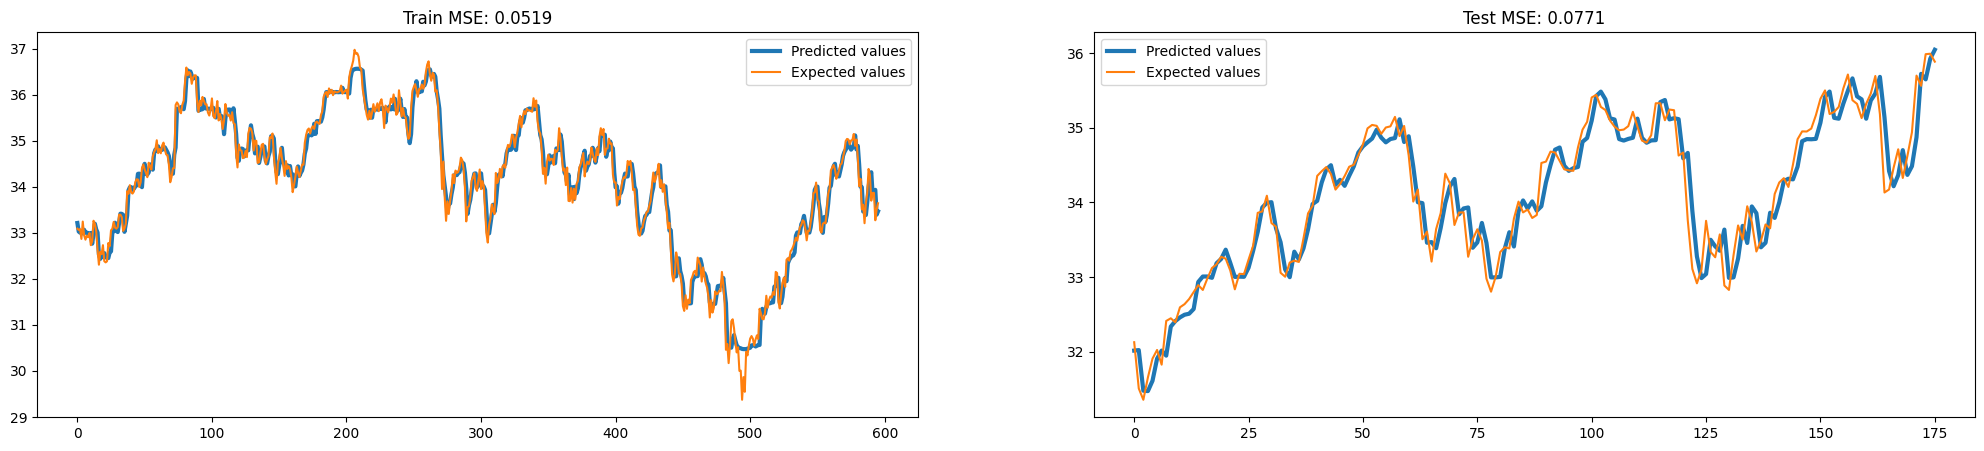

In [129]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Train MSE: {:.4f}'.format(train_mse_l10_w1))
ax1.plot(pred_train_l10_w1,label = "Predicted values",linewidth=3.0)
ax1.plot(trainY, label = "Expected values")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.title.set_text('Test MSE: {:.4f}'.format(test_mse_l10_w1))
ax2.plot(pred_test_l10_w1,label = "Predicted values",linewidth=3.0)
ax2.plot(testY, label = "Expected values")
ax2.legend()

In [19]:
np.savetxt("train_l10_w1.csv", pred_train_l10_w1, delimiter=",")
np.savetxt("pred_test_l10_w1.csv", pred_test_l10_w1, delimiter=",")

## Train with Deep-Regression-Forest `window = 2`


In [27]:
model_l10_w2 = Deep_Regression_Forest(window=2, stride=1, n_tree_grain=250, min_samples_grain=15,cascade_max_depth=None,max_layer=10,
                                   cascade_max_samples=0.7,n_estimator_cascade=3, n_tree_cascade=200, min_samples_cascade=17,verbose=1)
model_l10_w2.fit(trainX, trainY)

Training Multi_grain Sliding...
Layer validation MSE = 0.1414950614057008
Layer validation MSE = 0.13075964988994324
Layer validation MSE = 0.11705271818120964
Layer validation MSE = 0.10955343491636817
Layer validation MSE = 0.10539261579109241
Layer validation MSE = 0.10351601482397205
Layer validation MSE = 0.10578495163366383
Layer validation MSE = 0.10663682297147722


In [28]:
pred_train_l10_w2 = model_l10_w2.predict(trainX)   # Prediction of Train-set
pred_test_l10_w2 = model_l10_w2.predict(testX)     # Prediction of Test-set

train_mse_l10_w2 = mean_squared_error(trainY,pred_train_l10_w2)    # MSE Train
test_mse_l10_w2 = mean_squared_error(testY,pred_test_l10_w2)       # MSE Test

train_rmse_l10_w2 = np.sqrt(mean_squared_error(trainY,pred_train_l10_w2))    # RMSE Train
test_rmse_l10_w2 = np.sqrt(mean_squared_error(testY,pred_test_l10_w2))       # RMSE Test

train_mae_l10_w2 = mean_absolute_error(trainY,pred_train_l10_w2)    # MAE Train
test_mae_l10_w2 = mean_absolute_error(testY,pred_test_l10_w2)       # MAE Test

train_r2_l10_w2 = r2_score(trainY,pred_train_l10_w2)    # r2 Train
test_r2_l10_w2 = r2_score(testY,pred_test_l10_w2)       # r2 Test

# Print Errors
print("MSE Train: {:.4f}".format(train_mse_l10_w2))
print("MSE Test: {:.4f}".format(test_mse_l10_w2))
print(".........................")
print("RMSE Train: {:.4f}".format(train_rmse_l10_w2))
print("RMSE Test: {:.4f}".format(test_rmse_l10_w2))
print(".........................")
print("MAE Train: {:.4f}".format(train_mae_l10_w2))
print("MAE Test: {:.4f}".format(test_mae_l10_w2))
print(".........................")
print("R2 Train: {:.4f}".format(train_r2_l10_w2))
print("R2 Test: {:.4f}".format(test_r2_l10_w2))

MSE Train: 0.0465
MSE Test: 0.0859
.........................
RMSE Train: 0.2157
RMSE Test: 0.2931
.........................
MAE Train: 0.1566
MAE Test: 0.2171
.........................
R2 Train: 0.9798
R2 Test: 0.8909


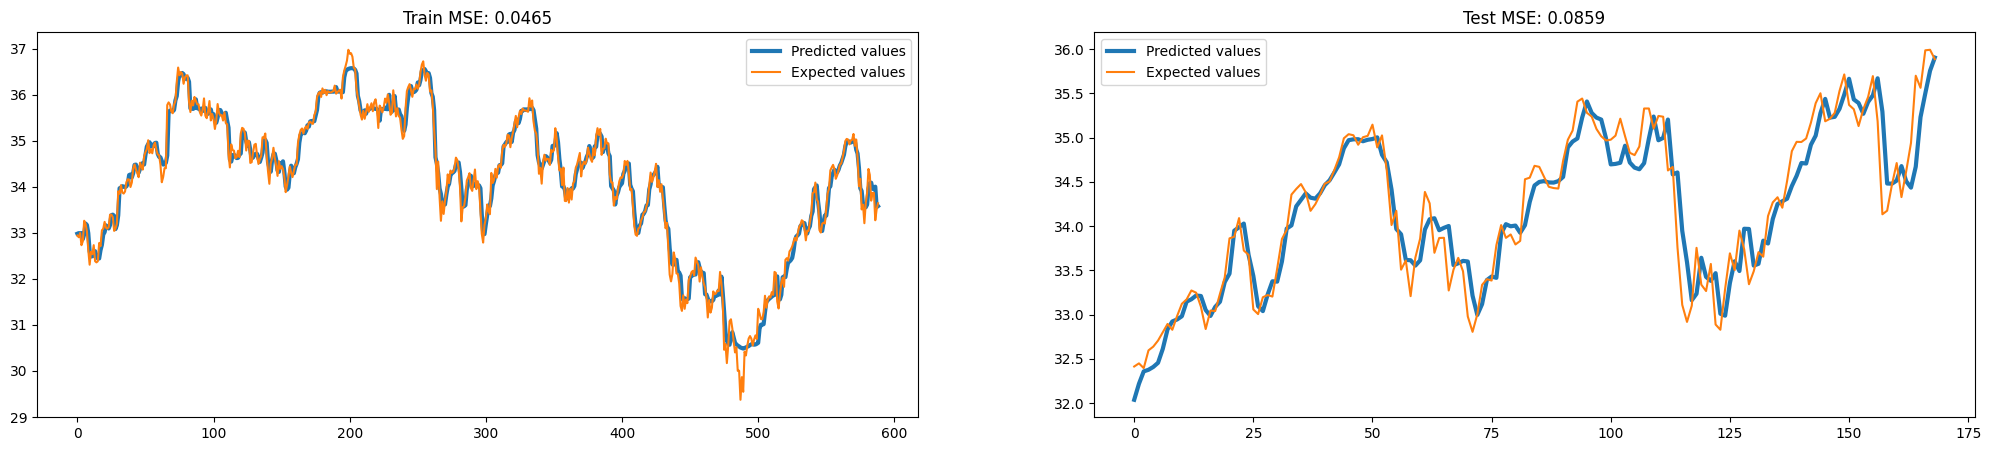

In [30]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Train MSE: {:.4f}'.format(train_mse_l10_w2))
ax1.plot(pred_train_l10_w2,label = "Predicted values",linewidth=3.0)
ax1.plot(trainY, label = "Expected values")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.title.set_text('Test MSE: {:.4f}'.format(test_mse_l10_w2))
ax2.plot(pred_test_l10_w2,label = "Predicted values",linewidth=3.0)
ax2.plot(testY, label = "Expected values")
ax2.legend()

In [31]:
np.savetxt("train_l10_w2.csv", pred_train_l10_w2, delimiter=",")
np.savetxt("pred_test_l10_w2.csv", pred_test_l10_w2, delimiter=",")

## Train with Deep-Regression-Forest `window = 5`

In [35]:
model_l10_w5 = Deep_Regression_Forest(window=5, stride=1, n_tree_grain=250, min_samples_grain=15,cascade_max_depth=None,max_layer=10,
                                   cascade_max_samples=0.7,n_estimator_cascade=3, n_tree_cascade=200, min_samples_cascade=17,verbose=1)
model_l10_w5.fit(trainX, trainY)

Training Multi_grain Sliding...
Layer validation MSE = 0.12025023055340506
Layer validation MSE = 0.12059950862688326
Layer validation MSE = 0.12367276623468562
Layer validation MSE = 0.11889672565935605
Layer validation MSE = 0.1168275758434671
Layer validation MSE = 0.11852959698883013


In [36]:
pred_train_l10_w5 = model_l10_w5.predict(trainX)   # Prediction of Train-set
pred_test_l10_w5 = model_l10_w5.predict(testX)     # Prediction of Test-set

train_mse_l10_w5 = mean_squared_error(trainY,pred_train_l10_w5)    # MSE Train
test_mse_l10_w5 = mean_squared_error(testY,pred_test_l10_w5)       # MSE Test

train_rmse_l10_w5 = np.sqrt(mean_squared_error(trainY,pred_train_l10_w5))    # RMSE Train
test_rmse_l10_w5 = np.sqrt(mean_squared_error(testY,pred_test_l10_w5))       # RMSE Test

train_mae_l10_w5 = mean_absolute_error(trainY,pred_train_l10_w5)    # MAE Train
test_mae_l10_w5 = mean_absolute_error(testY,pred_test_l10_w5)       # MAE Test

train_r2_l10_w5 = r2_score(trainY,pred_train_l10_w5)    # r2 Train
test_r2_l10_w5 = r2_score(testY,pred_test_l10_w5)       # r2 Test

# Print Errors
print("MSE Train: {:.4f}".format(train_mse_l10_w5))
print("MSE Test: {:.4f}".format(test_mse_l10_w5))
print(".........................")
print("RMSE Train: {:.4f}".format(train_rmse_l10_w5))
print("RMSE Test: {:.4f}".format(test_rmse_l10_w5))
print(".........................")
print("MAE Train: {:.4f}".format(train_mae_l10_w5))
print("MAE Test: {:.4f}".format(test_mae_l10_w5))
print(".........................")
print("R2 Train: {:.4f}".format(train_r2_l10_w5))
print("R2 Test: {:.4f}".format(test_r2_l10_w5))

MSE Train: 0.0437
MSE Test: 0.0949
.........................
RMSE Train: 0.2090
RMSE Test: 0.3081
.........................
MAE Train: 0.1519
MAE Test: 0.2262
.........................
R2 Train: 0.9811
R2 Test: 0.8795


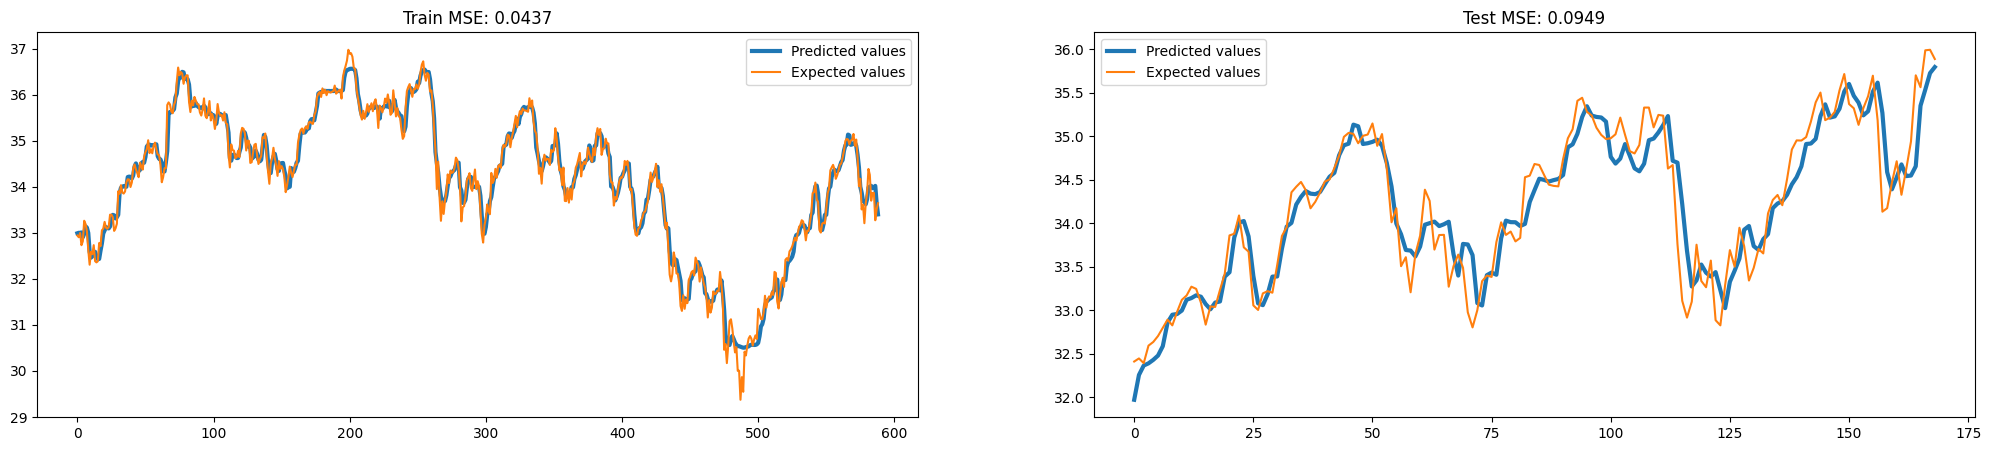

In [37]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Train MSE: {:.4f}'.format(train_mse_l10_w5))
ax1.plot(pred_train_l10_w5,label = "Predicted values",linewidth=3.0)
ax1.plot(trainY, label = "Expected values")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.title.set_text('Test MSE: {:.4f}'.format(test_mse_l10_w5))
ax2.plot(pred_test_l10_w5,label = "Predicted values",linewidth=3.0)
ax2.plot(testY, label = "Expected values")
ax2.legend()

In [38]:
np.savetxt("train_l10_w5.csv", pred_train_l10_w5, delimiter=",")
np.savetxt("pred_test_l10_w5.csv", pred_test_l10_w5, delimiter=",")

## Create Supervised data for training with `look_back = 5`

In [108]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [152]:
np.savetxt("train_l5.csv", trainY, delimiter=",")
np.savetxt("test_l5.csv", testY, delimiter=",")

## Train with Deep-Regression-Forest `window = 1`

In [111]:
model_l5_w1 = Deep_Regression_Forest(window=[1,2,3,4], stride=1, n_tree_grain=250, min_samples_grain=15,cascade_max_depth=None,max_layer=10,
                                   cascade_max_samples=0.7,n_estimator_cascade=3, n_tree_cascade=200, min_samples_cascade=17,verbose=1)
model_l5_w1.fit(trainX, trainY)

Training Multi_grain Sliding...
Training Multi_grain Sliding...
Training Multi_grain Sliding...
Training Multi_grain Sliding...


C:\Users\cybor\AppData\Local\Temp\ipykernel_23096\403845486.py:86: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  grain_features = np.hstack((grain_pred.values()))


Layer validation MSE = 0.11280413858262607
Layer validation MSE = 0.12087147063983869
Layer validation MSE = 0.11708524003648643
Layer validation MSE = 0.1158188299039769
Layer validation MSE = 0.10681295293662076
Layer validation MSE = 0.10780371162890033
Layer validation MSE = 0.10628592634536176
Layer validation MSE = 0.10634383313554997


In [112]:
pred_train_l5_w1 = model_l5_w1.predict(trainX)   # Prediction of Train-set
pred_test_l5_w1 = model_l5_w1.predict(testX)     # Prediction of Test-set

train_mse_l5_w1 = mean_squared_error(trainY,pred_train_l5_w1)    # MSE Train
test_mse_l5_w1 = mean_squared_error(testY,pred_test_l5_w1)       # MSE Test

train_rmse_l5_w1 = np.sqrt(mean_squared_error(trainY,pred_train_l5_w1))    # RMSE Train
test_rmse_l5_w1 = np.sqrt(mean_squared_error(testY,pred_test_l5_w1))       # RMSE Test

train_mae_l5_w1 = mean_absolute_error(trainY,pred_train_l5_w1)    # MAE Train
test_mae_l5_w1 = mean_absolute_error(testY,pred_test_l5_w1)       # MAE Test

train_r2_l5_w1 = r2_score(trainY,pred_train_l5_w1)    # r2 Train
test_r2_l5_w1 = r2_score(testY,pred_test_l5_w1)       # r2 Test

# Print Errors
print("MSE Train: {:.4f}".format(train_mse_l5_w1))
print("MSE Test: {:.4f}".format(test_mse_l5_w1))
print(".........................")
print("RMSE Train: {:.4f}".format(train_rmse_l5_w1))
print("RMSE Test: {:.4f}".format(test_rmse_l5_w1))
print(".........................")
print("MAE Train: {:.4f}".format(train_mae_l5_w1))
print("MAE Test: {:.4f}".format(test_mae_l5_w1))
print(".........................")
print("R2 Train: {:.4f}".format(train_r2_l5_w1))
print("R2 Test: {:.4f}".format(test_r2_l5_w1))

C:\Users\cybor\AppData\Local\Temp\ipykernel_23096\403845486.py:86: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  grain_features = np.hstack((grain_pred.values()))
C:\Users\cybor\AppData\Local\Temp\ipykernel_23096\403845486.py:86: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  grain_features = np.hstack((grain_pred.values()))


MSE Train: 0.0522
MSE Test: 0.0783
.........................
RMSE Train: 0.2285
RMSE Test: 0.2798
.........................
MAE Train: 0.1658
MAE Test: 0.2052
.........................
R2 Train: 0.9773
R2 Test: 0.9161


In [153]:
model_l5_w1.n_layer

9

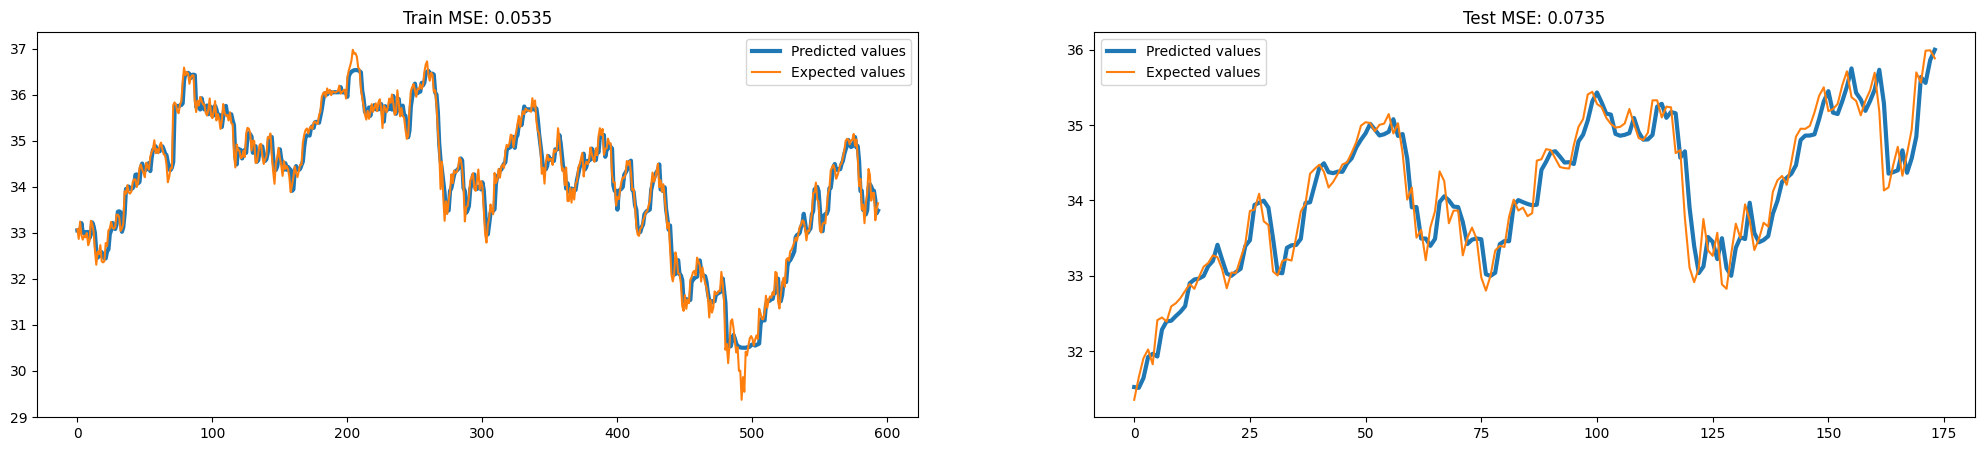

In [42]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Train MSE: {:.4f}'.format(train_mse_l5_w1))
ax1.plot(pred_train_l5_w1,label = "Predicted values",linewidth=3.0)
ax1.plot(trainY, label = "Expected values")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.title.set_text('Test MSE: {:.4f}'.format(test_mse_l5_w1))
ax2.plot(pred_test_l5_w1,label = "Predicted values",linewidth=3.0)
ax2.plot(testY, label = "Expected values")
ax2.legend()

In [43]:
np.savetxt("train_l5_w1.csv", pred_train_l5_w1, delimiter=",")
np.savetxt("pred_test_l5_w1.csv", pred_test_l5_w1, delimiter=",")

## Train with Deep-Regression-Forest `window = 2`

In [52]:
model_l5_w2 = Deep_Regression_Forest(window=2, stride=1, n_tree_grain=250, min_samples_grain=15,cascade_max_depth=None,max_layer=10,
                                   cascade_max_samples=0.7,n_estimator_cascade=3, n_tree_cascade=200, min_samples_cascade=17,verbose=1)
model_l5_w2.fit(trainX, trainY)

Training Multi_grain Sliding...
Layer validation MSE = 0.1233974036068385
Layer validation MSE = 0.12018635807575176
Layer validation MSE = 0.12116672964639767
Layer validation MSE = 0.11563020009357818
Layer validation MSE = 0.1160002078050634


In [53]:
pred_train_l5_w2 = model_l5_w2.predict(trainX)   # Prediction of Train-set
pred_test_l5_w2 = model_l5_w2.predict(testX)     # Prediction of Test-set

train_mse_l5_w2 = mean_squared_error(trainY,pred_train_l5_w2)    # MSE Train
test_mse_l5_w2 = mean_squared_error(testY,pred_test_l5_w2)       # MSE Test

train_rmse_l5_w2 = np.sqrt(mean_squared_error(trainY,pred_train_l5_w2))    # RMSE Train
test_rmse_l5_w2 = np.sqrt(mean_squared_error(testY,pred_test_l5_w2))       # RMSE Test

train_mae_l5_w2 = mean_absolute_error(trainY,pred_train_l5_w2)    # MAE Train
test_mae_l5_w2 = mean_absolute_error(testY,pred_test_l5_w2)       # MAE Test

train_r2_l5_w2 = r2_score(trainY,pred_train_l5_w2)    # r2 Train
test_r2_l5_w2 = r2_score(testY,pred_test_l5_w2)       # r2 Test

# Print Errors
print("MSE Train: {:.4f}".format(train_mse_l5_w2))
print("MSE Test: {:.4f}".format(test_mse_l5_w2))
print(".........................")
print("RMSE Train: {:.4f}".format(train_rmse_l5_w2))
print("RMSE Test: {:.4f}".format(test_rmse_l5_w2))
print(".........................")
print("MAE Train: {:.4f}".format(train_mae_l5_w2))
print("MAE Test: {:.4f}".format(test_mae_l5_w2))
print(".........................")
print("R2 Train: {:.4f}".format(train_r2_l5_w2))
print("R2 Test: {:.4f}".format(test_r2_l5_w2))

MSE Train: 0.0460
MSE Test: 0.0806
.........................
RMSE Train: 0.2145
RMSE Test: 0.2839
.........................
MAE Train: 0.1586
MAE Test: 0.2142
.........................
R2 Train: 0.9800
R2 Test: 0.9136


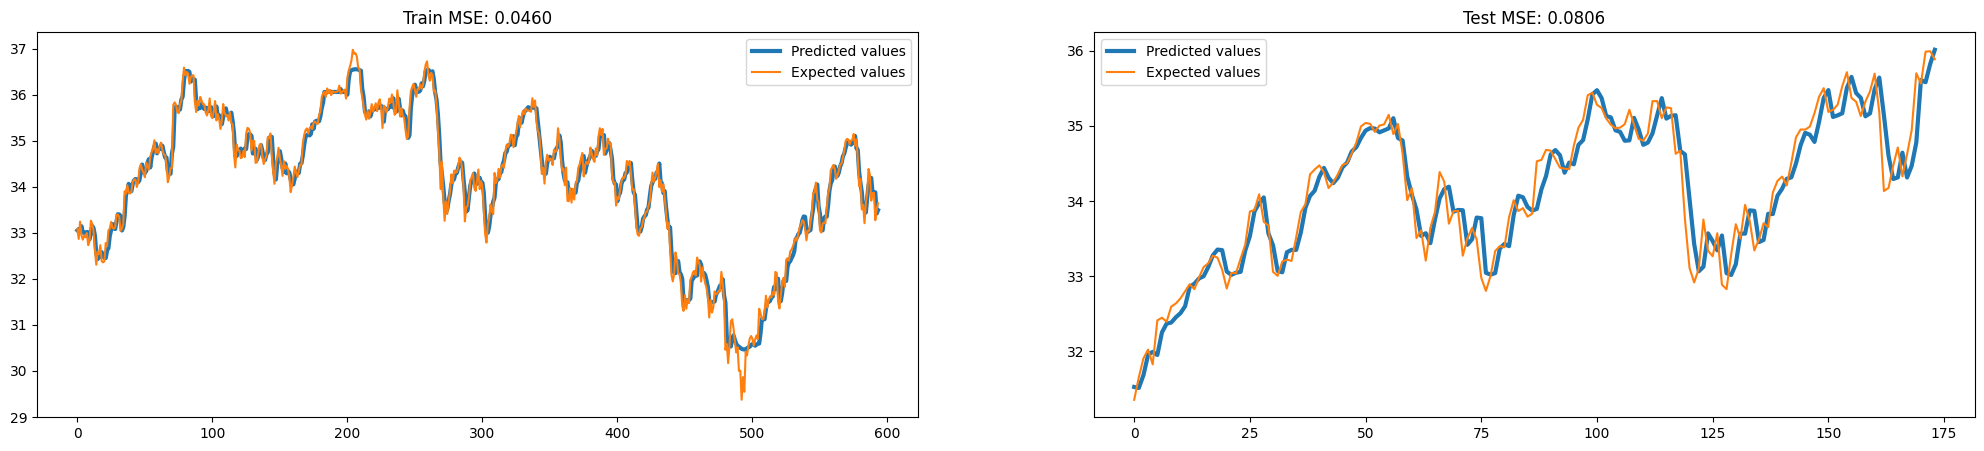

In [54]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Train MSE: {:.4f}'.format(train_mse_l5_w2))
ax1.plot(pred_train_l5_w2,label = "Predicted values",linewidth=3.0)
ax1.plot(trainY, label = "Expected values")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.title.set_text('Test MSE: {:.4f}'.format(test_mse_l5_w2))
ax2.plot(pred_test_l5_w2,label = "Predicted values",linewidth=3.0)
ax2.plot(testY, label = "Expected values")
ax2.legend()

In [55]:
np.savetxt("train_l5_w2.csv", pred_train_l5_w2, delimiter=",")
np.savetxt("pred_test_l5_w2.csv", pred_test_l5_w2, delimiter=",")

## Create Supervised data for training with `look_back = 3`

In [154]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [155]:
np.savetxt("train_l3.csv", trainY, delimiter=",")
np.savetxt("test_l3.csv", testY, delimiter=",")

## Train with Deep-Regression-Forest `window = 2`

In [72]:
model_l3_w2 = Deep_Regression_Forest(window=2, stride=1, n_tree_grain=250, min_samples_grain=15,cascade_max_depth=None,max_layer=10,
                                   cascade_max_samples=0.7,n_estimator_cascade=3, n_tree_cascade=200, min_samples_cascade=17,verbose=1)
model_l3_w2.fit(trainX, trainY)

Training Multi_grain Sliding...
Layer validation MSE = 0.1261832879762543
Layer validation MSE = 0.1139296214981604
Layer validation MSE = 0.12229617372574753
Layer validation MSE = 0.11791824022273803
Layer validation MSE = 0.11247124918954482
Layer validation MSE = 0.11546958228085837


In [73]:
pred_train_l3_w2 = model_l3_w2.predict(trainX)   # Prediction of Train-set
pred_test_l3_w2 = model_l3_w2.predict(testX)     # Prediction of Test-set

train_mse_l3_w2 = mean_squared_error(trainY,pred_train_l3_w2)    # MSE Train
test_mse_l3_w2 = mean_squared_error(testY,pred_test_l3_w2)       # MSE Test

train_rmse_l3_w2 = np.sqrt(mean_squared_error(trainY,pred_train_l3_w2))    # RMSE Train
test_rmse_l3_w2 = np.sqrt(mean_squared_error(testY,pred_test_l3_w2))       # RMSE Test

train_mae_l3_w2 = mean_absolute_error(trainY,pred_train_l3_w2)    # MAE Train
test_mae_l3_w2 = mean_absolute_error(testY,pred_test_l3_w2)       # MAE Test

train_r2_l3_w2 = r2_score(trainY,pred_train_l3_w2)    # r2 Train
test_r2_l3_w2 = r2_score(testY,pred_test_l3_w2)       # r2 Test

# Print Errors
print("MSE Train: {:.4f}".format(train_mse_l3_w2))
print("MSE Test: {:.4f}".format(test_mse_l3_w2))
print(".........................")
print("RMSE Train: {:.4f}".format(train_rmse_l3_w2))
print("RMSE Test: {:.4f}".format(test_rmse_l3_w2))
print(".........................")
print("MAE Train: {:.4f}".format(train_mae_l3_w2))
print("MAE Test: {:.4f}".format(test_mae_l3_w2))
print(".........................")
print("R2 Train: {:.4f}".format(train_r2_l3_w2))
print("R2 Test: {:.4f}".format(test_r2_l3_w2))

MSE Train: 0.0579
MSE Test: 0.0784
.........................
RMSE Train: 0.2405
RMSE Test: 0.2800
.........................
MAE Train: 0.1786
MAE Test: 0.2130
.........................
R2 Train: 0.9748
R2 Test: 0.9203


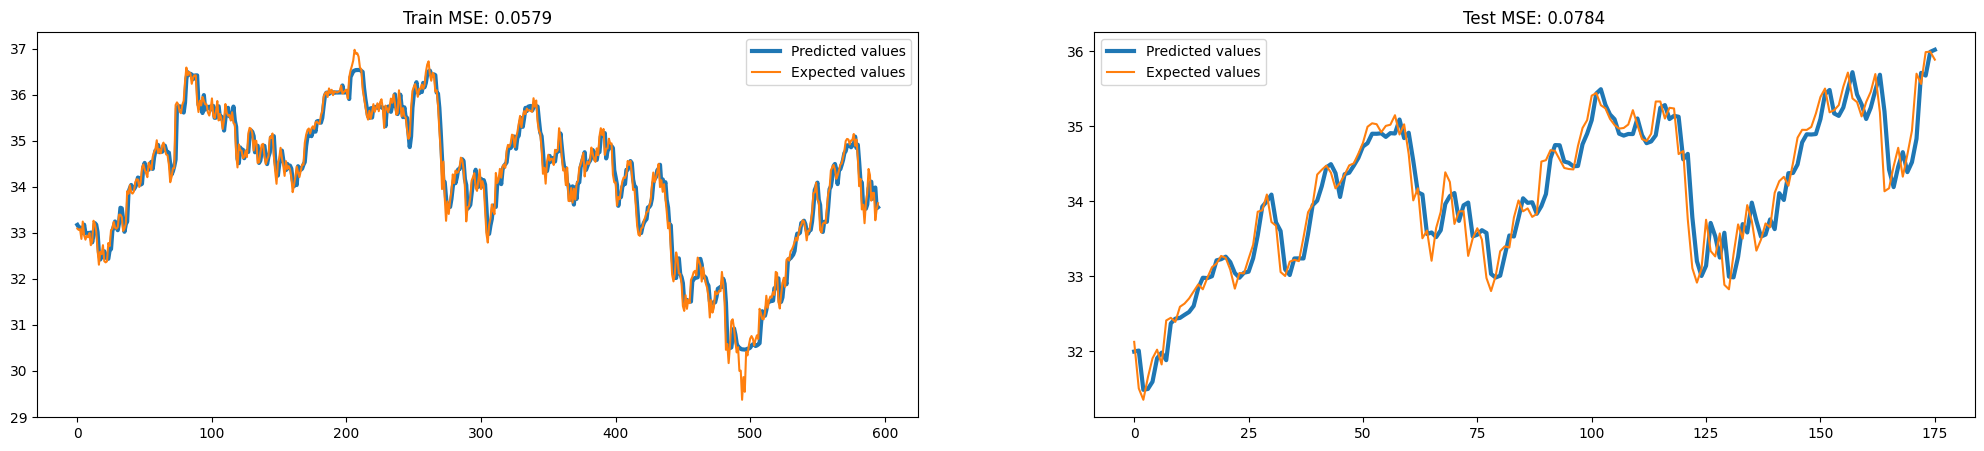

In [74]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Train MSE: {:.4f}'.format(train_mse_l3_w2))
ax1.plot(pred_train_l3_w2,label = "Predicted values",linewidth=3.0)
ax1.plot(trainY, label = "Expected values")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.title.set_text('Test MSE: {:.4f}'.format(test_mse_l3_w2))
ax2.plot(pred_test_l3_w2,label = "Predicted values",linewidth=3.0)
ax2.plot(testY, label = "Expected values")
ax2.legend()

In [75]:
np.savetxt("train_l3_w2.csv", pred_train_l3_w2, delimiter=",")
np.savetxt("pred_test_l3_w2.csv", pred_test_l3_w2, delimiter=",")

## Train with Deep-Regression-Forest `window = 1`

In [76]:
model_l3_w1 = Deep_Regression_Forest(window=1, stride=1, n_tree_grain=250, min_samples_grain=15,cascade_max_depth=None,max_layer=10,
                                   cascade_max_samples=0.7,n_estimator_cascade=3, n_tree_cascade=200, min_samples_cascade=17,verbose=1)
model_l3_w1.fit(trainX, trainY)

Training Multi_grain Sliding...
Layer validation MSE = 0.1210214098049953
Layer validation MSE = 0.12067062805274086
Layer validation MSE = 0.1240567225013279
Layer validation MSE = 0.12985672887203029


In [77]:
pred_train_l3_w1 = model_l3_w1.predict(trainX)   # Prediction of Train-set
pred_test_l3_w1 = model_l3_w1.predict(testX)     # Prediction of Test-set

train_mse_l3_w1 = mean_squared_error(trainY,pred_train_l3_w1)    # MSE Train
test_mse_l3_w1 = mean_squared_error(testY,pred_test_l3_w1)       # MSE Test

train_rmse_l3_w1 = np.sqrt(mean_squared_error(trainY,pred_train_l3_w1))    # RMSE Train
test_rmse_l3_w1 = np.sqrt(mean_squared_error(testY,pred_test_l3_w1))       # RMSE Test

train_mae_l3_w1 = mean_absolute_error(trainY,pred_train_l3_w1)    # MAE Train
test_mae_l3_w1 = mean_absolute_error(testY,pred_test_l3_w1)       # MAE Test

train_r2_l3_w1 = r2_score(trainY,pred_train_l3_w1)    # r2 Train
test_r2_l3_w1 = r2_score(testY,pred_test_l3_w1)       # r2 Test

# Print Errors
print("MSE Train: {:.4f}".format(train_mse_l3_w1))
print("MSE Test: {:.4f}".format(test_mse_l3_w1))
print(".........................")
print("RMSE Train: {:.4f}".format(train_rmse_l3_w1))
print("RMSE Test: {:.4f}".format(test_rmse_l3_w1))
print(".........................")
print("MAE Train: {:.4f}".format(train_mae_l3_w1))
print("MAE Test: {:.4f}".format(test_mae_l3_w1))
print(".........................")
print("R2 Train: {:.4f}".format(train_r2_l3_w1))
print("R2 Test: {:.4f}".format(test_r2_l3_w1))

MSE Train: 0.0497
MSE Test: 0.0749
.........................
RMSE Train: 0.2229
RMSE Test: 0.2737
.........................
MAE Train: 0.1651
MAE Test: 0.2072
.........................
R2 Train: 0.9784
R2 Test: 0.9238


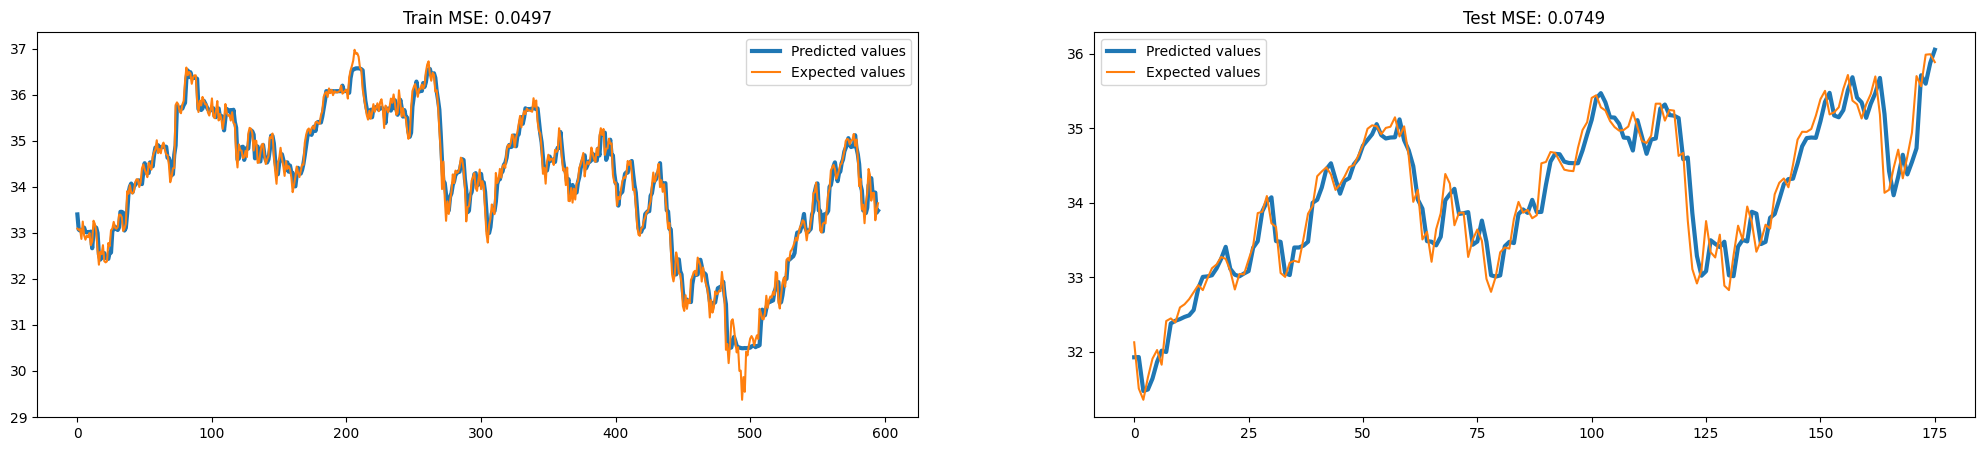

In [78]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Train MSE: {:.4f}'.format(train_mse_l3_w1))
ax1.plot(pred_train_l3_w1,label = "Predicted values",linewidth=3.0)
ax1.plot(trainY, label = "Expected values")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.title.set_text('Test MSE: {:.4f}'.format(test_mse_l3_w1))
ax2.plot(pred_test_l3_w1,label = "Predicted values",linewidth=3.0)
ax2.plot(testY, label = "Expected values")
ax2.legend()

In [79]:
np.savetxt("train_l3_w1.csv", pred_train_l3_w1, delimiter=",")
np.savetxt("pred_test_l3_w1.csv", pred_test_l3_w1, delimiter=",")

## Create Supervised data for training with `look_back = 2`

In [156]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [157]:
np.savetxt("train_l2.csv", trainY, delimiter=",")
np.savetxt("test_l2.csv", testY, delimiter=",")

## Train with Deep-Regression-Forest `window = 1`

In [95]:
model_l2_w1 = Deep_Regression_Forest(window=1, stride=1, n_tree_grain=250, min_samples_grain=15,cascade_max_depth=None,max_layer=10,
                                   cascade_max_samples=0.7,n_estimator_cascade=3, n_tree_cascade=200, min_samples_cascade=17,verbose=1)
model_l2_w1.fit(trainX, trainY)

Training Multi_grain Sliding...
Layer validation MSE = 0.1234828217931781
Layer validation MSE = 0.12708577185854908
Layer validation MSE = 0.12579312984480417
Layer validation MSE = 0.13053271923151907
Layer validation MSE = 0.12321278126527209
Layer validation MSE = 0.1200894969097818
Layer validation MSE = 0.11753632674274751
Layer validation MSE = 0.11823144203451298


In [96]:
pred_train_l2_w1 = model_l2_w1.predict(trainX)   # Prediction of Train-set
pred_test_l2_w1 = model_l2_w1.predict(testX)     # Prediction of Test-set

train_mse_l2_w1 = mean_squared_error(trainY,pred_train_l2_w1)    # MSE Train
test_mse_l2_w1 = mean_squared_error(testY,pred_test_l2_w1)       # MSE Test

train_rmse_l2_w1 = np.sqrt(mean_squared_error(trainY,pred_train_l2_w1))    # RMSE Train
test_rmse_l2_w1 = np.sqrt(mean_squared_error(testY,pred_test_l2_w1))       # RMSE Test

train_mae_l2_w1 = mean_absolute_error(trainY,pred_train_l2_w1)    # MAE Train
test_mae_l2_w1 = mean_absolute_error(testY,pred_test_l2_w1)       # MAE Test

train_r2_l2_w1 = r2_score(trainY,pred_train_l2_w1)    # r2 Train
test_r2_l2_w1 = r2_score(testY,pred_test_l2_w1)       # r2 Test

# Print Errors
print("MSE Train: {:.4f}".format(train_mse_l2_w1))
print("MSE Test: {:.4f}".format(test_mse_l2_w1))
print(".........................")
print("RMSE Train: {:.4f}".format(train_rmse_l2_w1))
print("RMSE Test: {:.4f}".format(test_rmse_l2_w1))
print(".........................")
print("MAE Train: {:.4f}".format(train_mae_l2_w1))
print("MAE Test: {:.4f}".format(test_mae_l2_w1))
print(".........................")
print("R2 Train: {:.4f}".format(train_r2_l2_w1))
print("R2 Test: {:.4f}".format(test_r2_l2_w1))

MSE Train: 0.0617
MSE Test: 0.0800
.........................
RMSE Train: 0.2483
RMSE Test: 0.2828
.........................
MAE Train: 0.1836
MAE Test: 0.2136
.........................
R2 Train: 0.9731
R2 Test: 0.9200


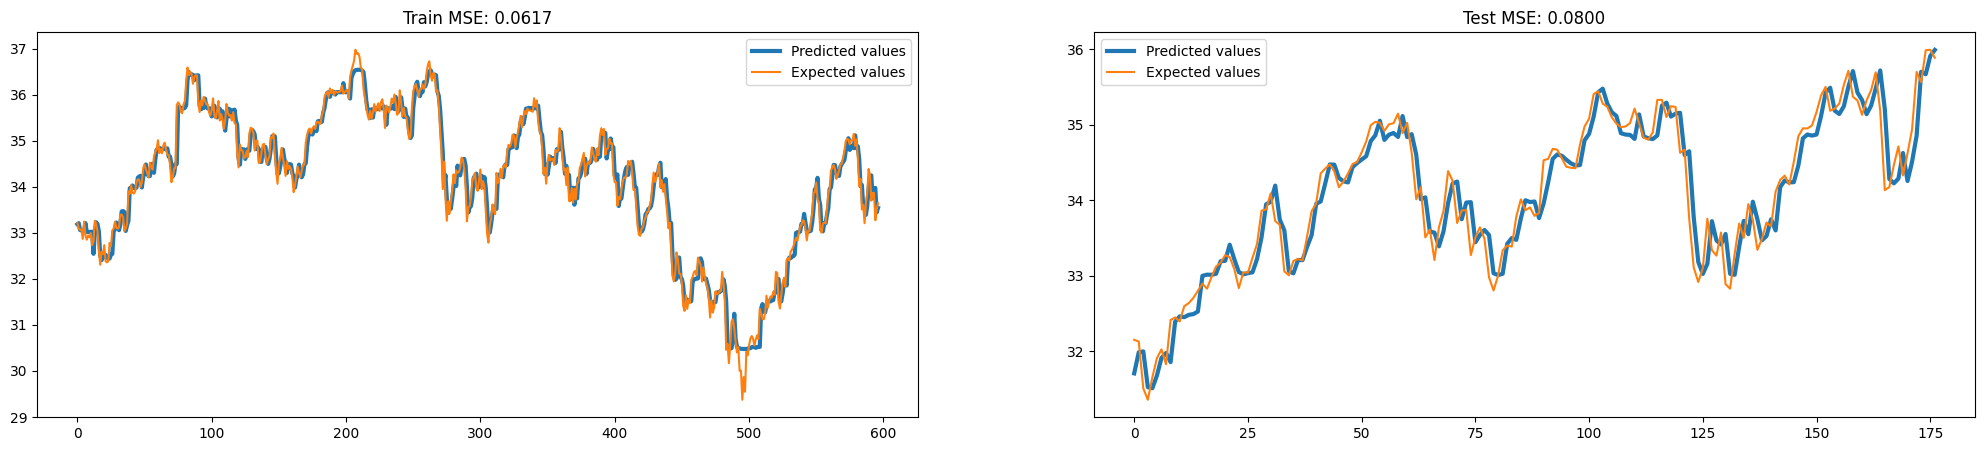

In [101]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Train MSE: {:.4f}'.format(train_mse_l2_w1))
ax1.plot(pred_train_l2_w1,label = "Predicted values",linewidth=3.0)
ax1.plot(trainY, label = "Expected values")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.title.set_text('Test MSE: {:.4f}'.format(test_mse_l2_w1))
ax2.plot(pred_test_l2_w1,label = "Predicted values",linewidth=3.0)
ax2.plot(testY, label = "Expected values")
ax2.legend()

In [150]:
np.savetxt("train_l2_w1.csv", pred_train_l2_w1, delimiter=",")
np.savetxt("pred_test_l2_w1.csv", pred_test_l2_w1, delimiter=",")

## Training with Deep Network

In [111]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [147]:
model = Sequential()
model.add(Dense(20, input_dim=look_back, activation='relu',kernel_regularizer=L2(0.02)))
model.add(Dense(12, activation='relu',kernel_regularizer=L2(0.02)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=150, batch_size=5, verbose=1)

Epoch 1/150
119/119 [==============================] - 1s 665us/step - loss: 98.0509
Epoch 2/150
119/119 [==============================] - 0s 798us/step - loss: 0.4245
Epoch 3/150
119/119 [==============================] - 0s 798us/step - loss: 0.3784
Epoch 4/150
119/119 [==============================] - 0s 887us/step - loss: 0.3613
Epoch 5/150
119/119 [==============================] - 0s 665us/step - loss: 0.3529
Epoch 6/150
119/119 [==============================] - 0s 665us/step - loss: 0.3497
Epoch 7/150
119/119 [==============================] - 0s 665us/step - loss: 0.3531
Epoch 8/150
119/119 [==============================] - 0s 666us/step - loss: 0.3470
Epoch 9/150
119/119 [==============================] - 0s 981us/step - loss: 0.3477
Epoch 10/150
119/119 [==============================] - 0s 1ms/step - loss: 0.3474
Epoch 11/150
119/119 [==============================] - 0s 1ms/step - loss: 0.3435
Epoch 12/150
119/119 [==============================] - 0s 1ms/step - loss: 0

In [148]:
pred_train = model.predict(trainX)   # Prediction of Train-set
pred_test = model.predict(testX)     # Prediction of Test-set

train_mse = mean_squared_error(trainY,pred_train)    # MSE Train
test_mse = mean_squared_error(testY,pred_test)       # MSE Test

train_rmse = np.sqrt(mean_squared_error(trainY,pred_train))    # RMSE Train
test_rmse = np.sqrt(mean_squared_error(testY,pred_test))       # RMSE Test

train_mae = mean_absolute_error(trainY,pred_train)    # MAE Train
test_mae = mean_absolute_error(testY,pred_test)       # MAE Test

train_r2 = r2_score(trainY,pred_train)    # r2 Train
test_r2 = r2_score(testY,pred_test)       # r2 Test

# Print Errors
print("MSE Train: {:.4f}".format(train_mse))
print("MSE Test: {:.4f}".format(test_mse))
print(".........................")
print("RMSE Train: {:.4f}".format(train_rmse))
print("RMSE Test: {:.4f}".format(test_rmse))
print(".........................")
print("MAE Train: {:.4f}".format(train_mae))
print("MAE Test: {:.4f}".format(test_mae))
print(".........................")
print("R2 Train: {:.4f}".format(train_r2))
print("R2 Test: {:.4f}".format(test_r2))

6/6 [==============================] - 0s 0s/step
MSE Train: 0.0949
MSE Test: 0.1252
.........................
RMSE Train: 0.3081
RMSE Test: 0.3539
.........................
MAE Train: 0.2353
MAE Test: 0.2729
.........................
R2 Train: 0.9587
R2 Test: 0.8658


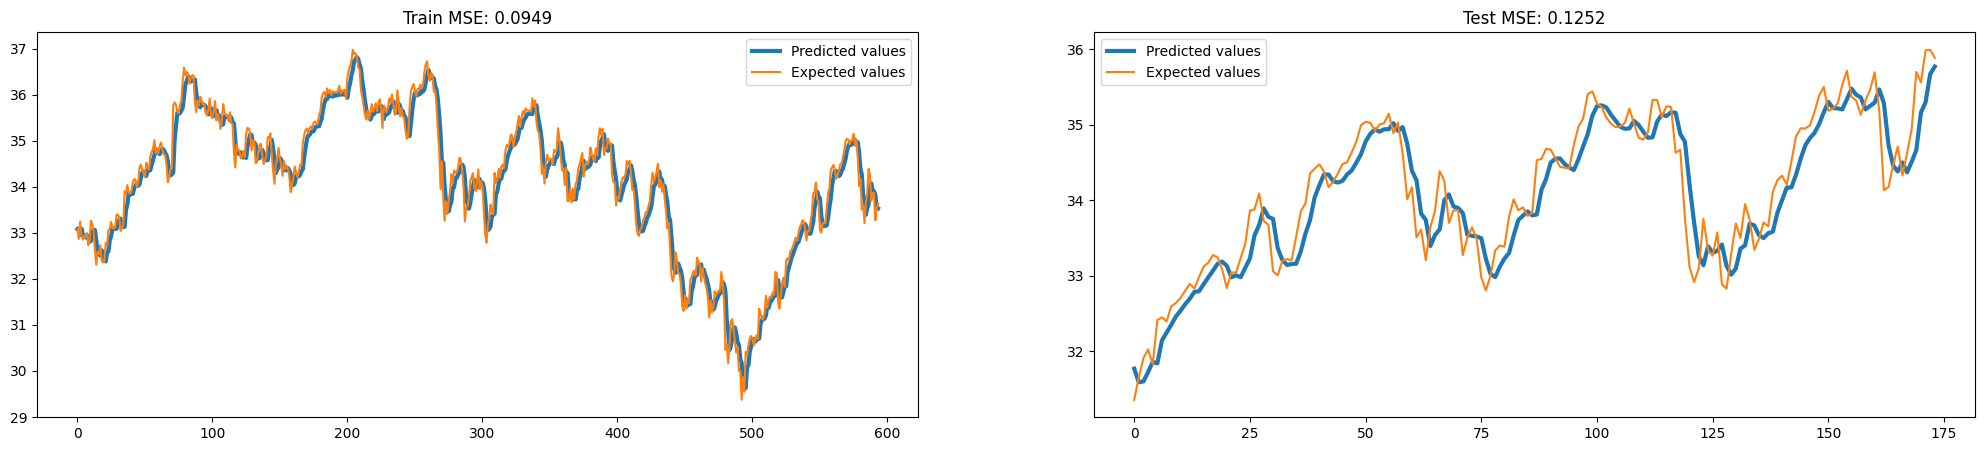

In [149]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Train MSE: {:.4f}'.format(train_mse))
ax1.plot(pred_train,label = "Predicted values",linewidth=3.0)
ax1.plot(trainY, label = "Expected values")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.title.set_text('Test MSE: {:.4f}'.format(test_mse))
ax2.plot(pred_test,label = "Predicted values",linewidth=3.0)
ax2.plot(testY, label = "Expected values")
ax2.legend()